## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:



where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. Let's prove that it works.

Metropolis-Hastings algorithm is build on the detailed balance ipothesis:

$$T(\theta_{i+1}|\theta_i)p(\theta_i) = T(\theta_{i}|\theta_{i+1})p(\theta_{i+1})$$

Let's devide the transition probability in a (symmetric) proposal probability $q(\theta_{i+1}|\theta_{i}) = q(\theta_{i}|\theta_{i+1})$ (often a gaussian centered on the current point) and an acceptance probability 

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = \min \left( { p(\theta_{i+1}) \over p(\theta_i) }, 1\right)$$

therefore:

$$
\min\left(1, \frac{p(\theta_{i+1})}{p(\theta_i)}\right) \, q(\theta_{i+1}|\theta_i) \, p(\theta_i)
= \min\left(1, \frac{p(\theta_i)}{p(\theta_{i+1})}\right) \, q(\theta_i|\theta_{i+1}) \, p(\theta_{i+1})
$$

In the expression above the $q$ cancels out, due to it's symmetry. Suppose $p(\theta_{i+1})>p(\theta_i)$. Then:
$$\min\left(1, \frac{p(\theta_i)}{p(\theta_{i+1})}\right)=\frac{p(\theta_i)}{p(\theta_{i+1})}$$
We get:
$$
1\cdot p(\theta_i) = \frac{p(\theta_i)}{p(\theta_{i+1})}\cdot p(\theta_{i+1})
$$
detailed balance is assured. This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$. M-H algorithm always accepts points of higher probability (if $p(\theta_{i+1})>p(\theta_{i})$ then $p_{\rm acc} = 1$), but can also accept points of lower probability, sometimes.
5. ***If $\theta_{i+1}$ is accepted added it to the chain. If not, add $\theta_{i}$ to the chain.***
6. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from 

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements). 

***Step 4*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from IPython.display import display, HTML
from scipy.stats import multivariate_normal

def metropolis_hastings_animation(target_pdf, initial=[0.0, 0.0], proposal_std=0.3, frames=100, filename='metropolis_hastings.gif'):
    samples = [np.array(initial)]

    fig, ax = plt.subplots(figsize=(8, 8))

    # Background heatmap of target PDF
    x = np.linspace(-3, 3, 200)
    y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    Z = np.array([target_pdf(p) for p in pos.reshape(-1, 2)]).reshape(200, 200)
    ax.imshow(Z, extent=[-3, 3, -3, 3], origin='lower', cmap='viridis', alpha=0.5)
    ax.set_title("Metropolis-Hastings Sampling")
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    scat = ax.scatter([], [], color='red', s=10)
    path_line, = ax.plot([], [], color='white', lw=0.5)
    arrow = FancyArrowPatch((0, 0), (0, 0), arrowstyle="->", color='gray', mutation_scale=15)
    ax.add_patch(arrow)

    text_current = ax.text(0, 0, '', color='white', fontsize=8)
    text_proposal = ax.text(0, 0, '', color='white', fontsize=8)
    text_alpha = ax.text(0, 0, '', color='white', fontsize=8)

    def init():
        scat.set_offsets(np.empty((0, 2)))
        path_line.set_data([], [])
        arrow.set_visible(False)
        text_current.set_text('')
        text_proposal.set_text('')
        text_alpha.set_text('')
        return scat, path_line, arrow, text_current, text_proposal, text_alpha

    def update(frame):
        current = samples[-1]
        proposal = current + np.random.normal(scale=proposal_std, size=2)

        p_current = target_pdf(current)
        p_proposal = target_pdf(proposal)
        alpha = min(1, p_proposal / p_current)

        if np.random.rand() < alpha:
            samples.append(proposal)
            arrow.set_color('green')
        else:
            samples.append(current)
            arrow.set_color('red')

        path = np.array(samples)
        scat.set_offsets(path)
        path_line.set_data(path[:, 0], path[:, 1])

        arrow.set_positions((current[0], current[1]), (proposal[0], proposal[1]))
        arrow.set_visible(True)

        mid_x = (current[0] + proposal[0]) / 2
        mid_y = (current[1] + proposal[1]) / 2

        text_current.set_position((mid_x + 0.1, mid_y + 0.1))
        text_current.set_text(f"p(current)={p_current:.3f}")

        text_proposal.set_position((mid_x + 0.1, mid_y))
        text_proposal.set_text(f"p(proposal)={p_proposal:.3f}")

        text_alpha.set_position((mid_x + 0.1, mid_y - 0.1))
        text_alpha.set_text(f"p(acc)={alpha:.3f}")

        return scat, path_line, arrow, text_current, text_proposal, text_alpha

    ani = FuncAnimation(fig, update, init_func=init, frames=frames, interval=200, blit=False)

    ani.save(filename, writer="pillow", fps=5)
    #display(HTML(ani.to_jshtml()))
    plt.close()

    return np.array(samples)
    

In [4]:
def target_pdf(x):
    gauss1 = multivariate_normal(mean=[1, 0], cov=[[0.3, 0], [0, 0.3]])
    gauss2 = multivariate_normal(mean=[-1, 1], cov=[[0.5, 0], [0, 0.5]])
    return gauss1.pdf(x) + gauss2.pdf(x)

samples = metropolis_hastings_animation(target_pdf, initial=[0, 0], proposal_std=0.5, frames=200, filename='metropolis_hastings.gif')

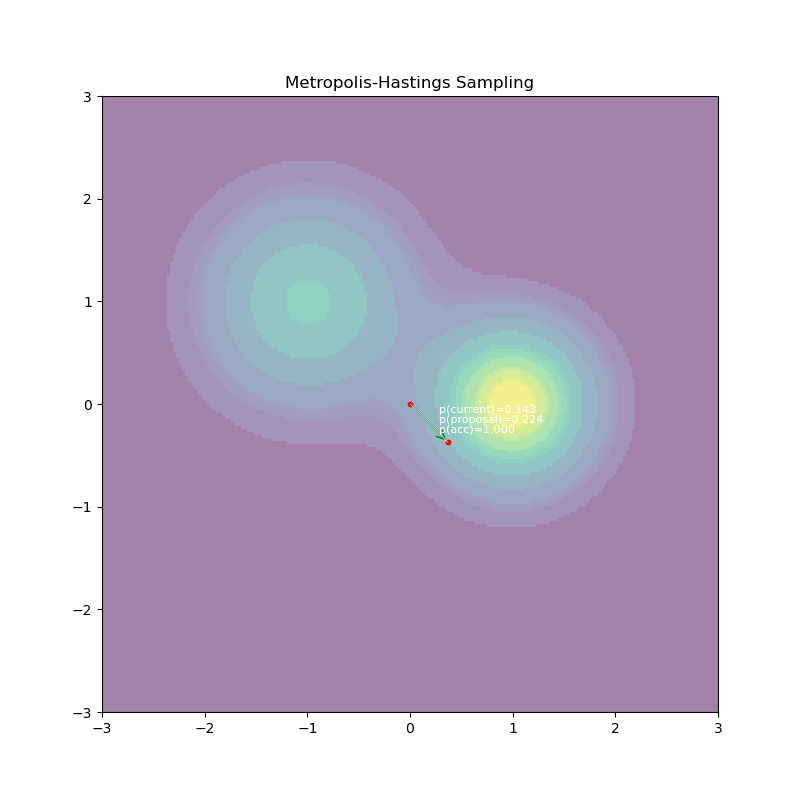

In [5]:
from IPython.display import Image, Video
# For GIF:
Image("metropolis_hastings.gif")

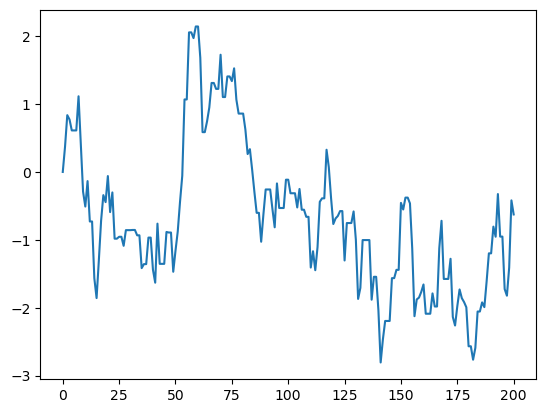

In [6]:
plt.plot(range(len(samples[:,0])),samples[:,0])

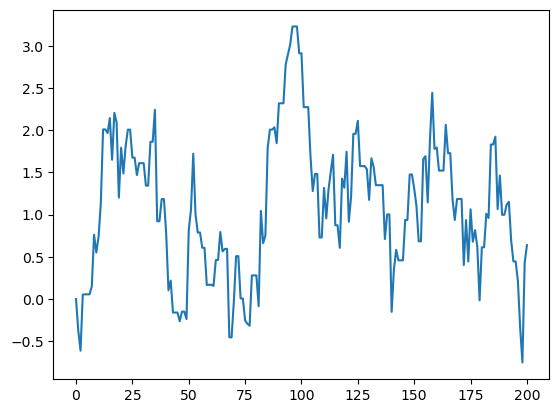

In [7]:
plt.plot(range(len(samples[:,1])),samples[:,1])

In [9]:
def target_pdf(x):
    gauss1 = multivariate_normal(mean=[1, 0], cov=[[0.3, 0], [0, 0.3]])
    gauss2 = multivariate_normal(mean=[-1, 1], cov=[[0.5, 0], [0, 0.5]])
    return gauss1.pdf(x) + gauss2.pdf(x)

samples = metropolis_hastings_animation(target_pdf, initial=[0, 0], proposal_std=0.1, frames=200, filename='metropolis_hastings_2.gif')

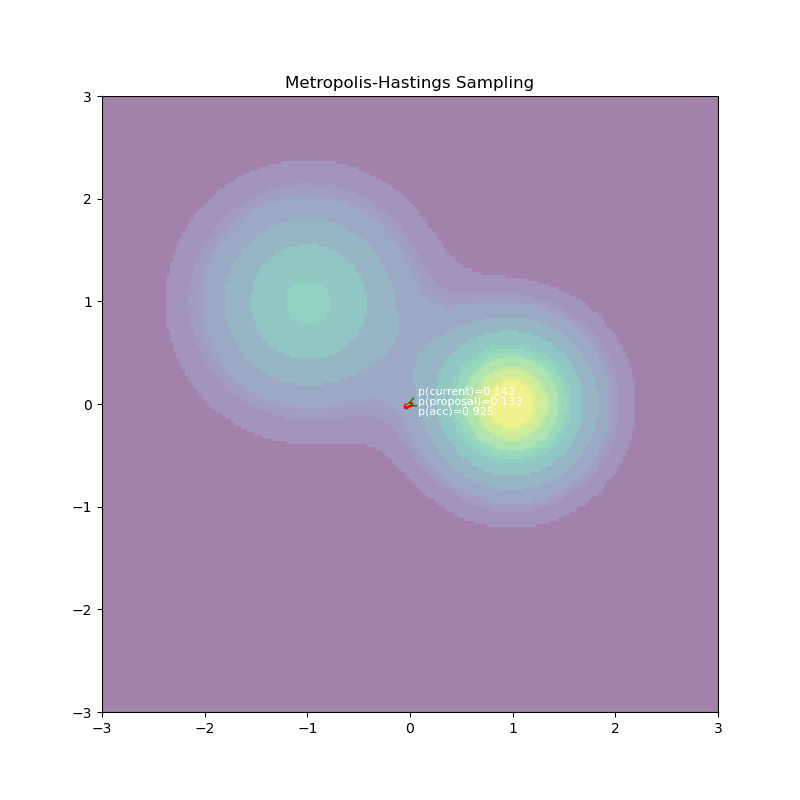

In [10]:
from IPython.display import Image, Video
# For GIF:
Image("metropolis_hastings_2.gif")

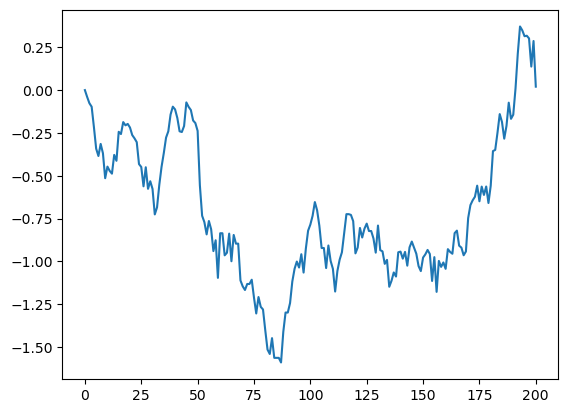

In [11]:
plt.plot(range(len(samples[:,0])),samples[:,0])

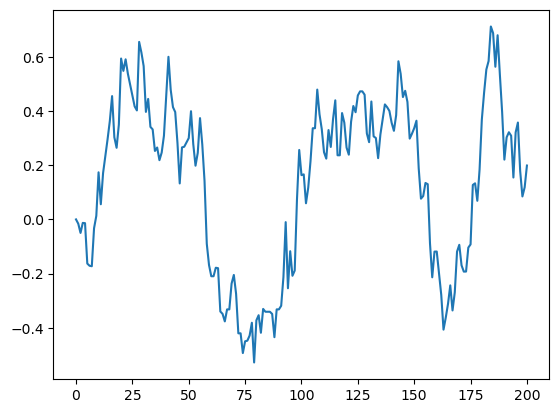

In [12]:
plt.plot(range(len(samples[:,1])),samples[:,1])